In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

print("="*80)
print("АВТОМАТИЧЕСКАЯ КЛАССИФИКАЦИЯ БАНКОВСКИХ ОПЕРАЦИЙ")
print("="*80)

АВТОМАТИЧЕСКАЯ КЛАССИФИКАЦИЯ БАНКОВСКИХ ОПЕРАЦИЙ


In [4]:
# Загрузка данных
df = pd.read_csv('ci_data.csv')
print(f"Исходный размер данных: {df.shape}")
print(f"\nСтолбцы: {df.columns.tolist()}")
print(f"\nТипы данных:\n{df.dtypes}")

# Просмотр первых строк
print("\nПервые 5 строк данных:")
display(df.head())

Исходный размер данных: (1470, 7)

Столбцы: ['Date', 'Category', 'RefNo', 'Date.1', 'Withdrawal', 'Deposit', 'Balance']

Типы данных:
Date           object
Category       object
RefNo          object
Date.1         object
Withdrawal    float64
Deposit       float64
Balance       float64
dtype: object

Первые 5 строк данных:


,Date,Category,RefNo,Date.1,Withdrawal,Deposit,Balance
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/1/2023,Rent,3.00E+11,1/1/2023,3950.0,0.0,1837.23
2,3/1/2023,Misc,3.00E+11,3/1/2023,105.0,0.0,1732.23
3,3/1/2023,Misc,3.37E+11,3/1/2023,0.0,55.0,1787.23
4,3/1/2023,Food,3.00E+11,3/1/2023,56.0,0.0,1731.23


In [5]:
def simple_preprocessing(df):
    """Простая предобработка с фокусом на правила"""

    df_processed = df.copy()

    # Удаление дублирующих колонок
    if 'Date.1' in df_processed.columns:
        df_processed = df_processed.drop('Date.1', axis=1)

    # Преобразование даты
    df_processed['Date'] = pd.to_datetime(df_processed['Date'], errors='coerce', dayfirst=True)
    df_processed = df_processed.dropna(subset=['Date'])

    # Создание суммы операции
    df_processed['Amount'] = df_processed.apply(
        lambda x: -x['Withdrawal'] if x['Withdrawal'] > 0 else x['Deposit'],
        axis=1
    )

    # Удаление нулевых операций
    df_processed = df_processed[df_processed['Amount'] != 0]

    # Базовые временные признаки
    df_processed['Month'] = df_processed['Date'].dt.month
    df_processed['Day'] = df_processed['Date'].dt.day
    df_processed['DayOfWeek'] = df_processed['Date'].dt.dayofweek

    # RefNo как строка
    df_processed['RefNo'] = df_processed['RefNo'].astype(str)

    return df_processed

df_processed = simple_preprocessing(df)
print(f"\nПосле очистки: {df_processed.shape}")
print("\nПервые 5 строк после обработки:")
display(df_processed.head())


После очистки: (569, 10)

Первые 5 строк после обработки:


,Date,Category,RefNo,Withdrawal,Deposit,Balance,Amount,Month,Day,DayOfWeek
1,2023-01-01,Rent,3.00E+11,3950.0,0.0,1837.23,-3950.0,1,1,6
2,2023-01-03,Misc,3.00E+11,105.0,0.0,1732.23,-105.0,1,3,1
3,2023-01-03,Misc,3.37E+11,0.0,55.0,1787.23,55.0,1,3,1
4,2023-01-03,Food,3.00E+11,56.0,0.0,1731.23,-56.0,1,3,1
5,2023-01-03,Misc,3.37E+11,1.0,0.0,1730.23,-1.0,1,3,1



Распределение категорий:
Category
Food         356
Misc         195
Shopping       9
Rent           7
Transport      2
Name: count, dtype: int64


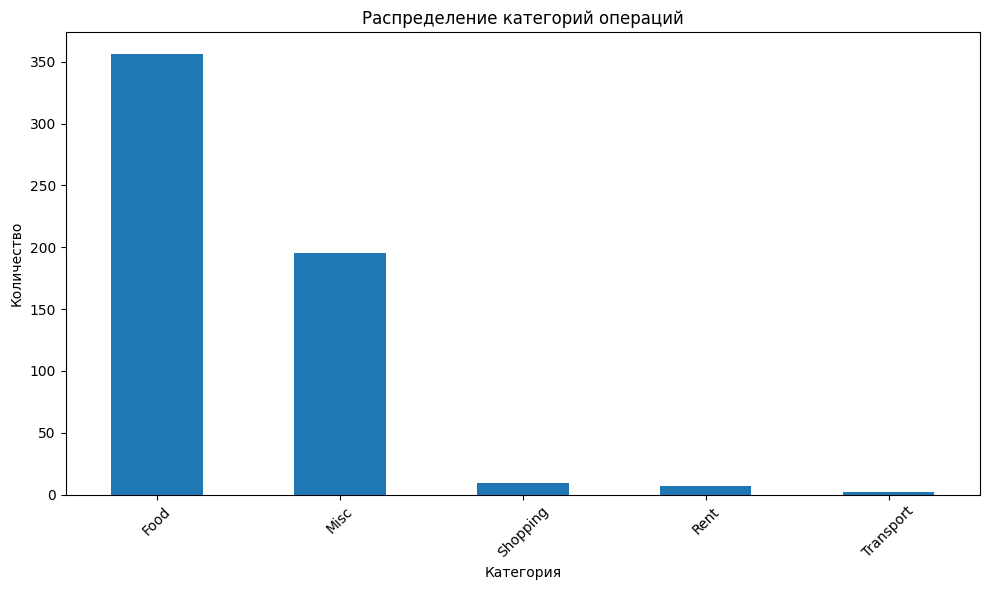

In [6]:
print(f"\nРаспределение категорий:")
category_counts = df_processed['Category'].value_counts()
print(category_counts)

# Визуализация распределения категорий
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Распределение категорий операций')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
def add_synthetic_data(df):
    """Добавление синтетических данных для редких категорий"""

    synthetic_rows = []

    # Создаем синтетические данные для редких категорий
    for category in df['Category'].unique():
        cat_samples = df[df['Category'] == category]
        num_samples = len(cat_samples)

        # Если категория редкая (< 50 примеров), добавляем синтетические данные
        if num_samples < 50 and num_samples > 0:
            print(f"\nДобавляем синтетические данные для категории '{category}' ({num_samples} → {num_samples * 5}):")

            for _, sample in cat_samples.iterrows():
                # Создаем 4 синтетических примера на каждый реальный
                for i in range(4):
                    new_sample = sample.copy()

                    # Добавляем небольшой шум к сумме (±10%)
                    if new_sample['Amount'] != 0:
                        noise = np.random.uniform(-0.1, 0.1)
                        new_sample['Amount'] = new_sample['Amount'] * (1 + noise)

                    # Добавляем шум к дате (±2 дня)
                    day_noise = np.random.randint(-2, 3)
                    new_day = max(1, min(31, new_sample['Day'] + day_noise))
                    new_sample['Day'] = new_day

                    synthetic_rows.append(new_sample)

    # Добавляем синтетические строки
    if synthetic_rows:
        synthetic_df = pd.DataFrame(synthetic_rows)
        df_augmented = pd.concat([df, synthetic_df], ignore_index=True)
    else:
        df_augmented = df.copy()

    print(f"\nДанные после добавления синтетических: {df_augmented.shape}")
    print("Новое распределение категорий:")
    print(df_augmented['Category'].value_counts())

    return df_augmented

# Добавляем синтетические данные
df_augmented = add_synthetic_data(df_processed)


Добавляем синтетические данные для категории 'Rent' (7 → 35):

Добавляем синтетические данные для категории 'Shopping' (9 → 45):

Добавляем синтетические данные для категории 'Transport' (2 → 10):

Данные после добавления синтетических: (641, 10)
Новое распределение категорий:
Category
Food         356
Misc         195
Shopping      45
Rent          35
Transport     10
Name: count, dtype: int64


In [8]:
def create_features(df):
    """Создание признаков для модели"""

    df_features = df.copy()

    # Базовые признаки суммы
    df_features['Amount_Abs'] = abs(df_features['Amount'])
    df_features['Is_Positive'] = (df_features['Amount'] > 0).astype(int)
    df_features['Is_Negative'] = (df_features['Amount'] < 0).astype(int)

    # Признаки RefNo
    df_features['RefNo_Upper'] = df_features['RefNo'].str.upper()
    df_features['Has_CHAS'] = df_features['RefNo_Upper'].str.contains('CHAS').astype(int)
    df_features['Has_E11'] = df_features['RefNo_Upper'].str.contains('E\+11').astype(int)

    # Признаки дня
    df_features['Is_FirstWeek'] = (df_features['Day'] <= 7).astype(int)
    df_features['Is_Weekend'] = (df_features['DayOfWeek'] >= 5).astype(int)

    # Признаки для конкретных категорий (основанные на правилах)
    df_features['Is_Large_Positive'] = (df_features['Amount'] > 5000).astype(int)
    df_features['Is_Medium_Negative'] = ((df_features['Amount'] < -100) & (df_features['Amount'] > -5000)).astype(int)
    df_features['Is_Small_Negative'] = ((df_features['Amount'] < 0) & (df_features['Amount'] > -500)).astype(int)

    return df_features

df_features = create_features(df_augmented)
print("Признаки созданы. Размер данных:", df_features.shape)
print("\nНовые признаки:")
display(df_features.head())

Признаки созданы. Размер данных: (641, 21)

Новые признаки:


,Date,Category,RefNo,Withdrawal,Deposit,Balance,Amount,Month,Day,DayOfWeek,...,Is_Positive,Is_Negative,RefNo_Upper,Has_CHAS,Has_E11,Is_FirstWeek,Is_Weekend,Is_Large_Positive,Is_Medium_Negative,Is_Small_Negative
0,2023-01-01,Rent,3.00E+11,3950.0,0.0,1837.23,-3950.0,1,1,6,...,0,1,3.00E+11,0,1,1,1,0,1,0
1,2023-01-03,Misc,3.00E+11,105.0,0.0,1732.23,-105.0,1,3,1,...,0,1,3.00E+11,0,1,1,0,0,1,1
2,2023-01-03,Misc,3.37E+11,0.0,55.0,1787.23,55.0,1,3,1,...,1,0,3.37E+11,0,1,1,0,0,0,0
3,2023-01-03,Food,3.00E+11,56.0,0.0,1731.23,-56.0,1,3,1,...,0,1,3.00E+11,0,1,1,0,0,0,1
4,2023-01-03,Misc,3.37E+11,1.0,0.0,1730.23,-1.0,1,3,1,...,0,1,3.37E+11,0,1,1,0,0,0,1


In [9]:
# Кодирование категорий
le_category = LabelEncoder()
df_features['Category_Encoded'] = le_category.fit_transform(df_features['Category'])
categories = le_category.classes_
category_mapping = {i: cat for i, cat in enumerate(categories)}

print(f"\nКодированные категории: {category_mapping}")

# Выбор признаков
feature_columns = [
    'Amount', 'Amount_Abs',
    'Is_Positive', 'Is_Negative',
    'Is_Large_Positive', 'Is_Medium_Negative', 'Is_Small_Negative',
    'Month', 'Day', 'DayOfWeek',
    'Is_FirstWeek', 'Is_Weekend',
    'Has_CHAS', 'Has_E11'
]

X = df_features[feature_columns].fillna(0)
y = df_features['Category_Encoded']

print(f"\nПризнаки: {feature_columns}")
print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nОбучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")


Кодированные категории: {0: 'Food', 1: 'Misc', 2: 'Rent', 3: 'Shopping', 4: 'Transport'}

Признаки: ['Amount', 'Amount_Abs', 'Is_Positive', 'Is_Negative', 'Is_Large_Positive', 'Is_Medium_Negative', 'Is_Small_Negative', 'Month', 'Day', 'DayOfWeek', 'Is_FirstWeek', 'Is_Weekend', 'Has_CHAS', 'Has_E11']
Размер X: (641, 14)
Размер y: (641,)

Обучающая выборка: (512, 14)
Тестовая выборка: (129, 14)



ОБУЧЕНИЕ МОДЕЛИ
Обучаем Random Forest...

Accuracy модели: 0.9225

Classification Report:
              precision    recall  f1-score   support

        Food       0.94      0.93      0.94        72
        Misc       0.86      0.92      0.89        39
        Rent       1.00      1.00      1.00         7
    Shopping       1.00      0.78      0.88         9
   Transport       1.00      1.00      1.00         2

    accuracy                           0.92       129
   macro avg       0.96      0.93      0.94       129
weighted avg       0.93      0.92      0.92       129



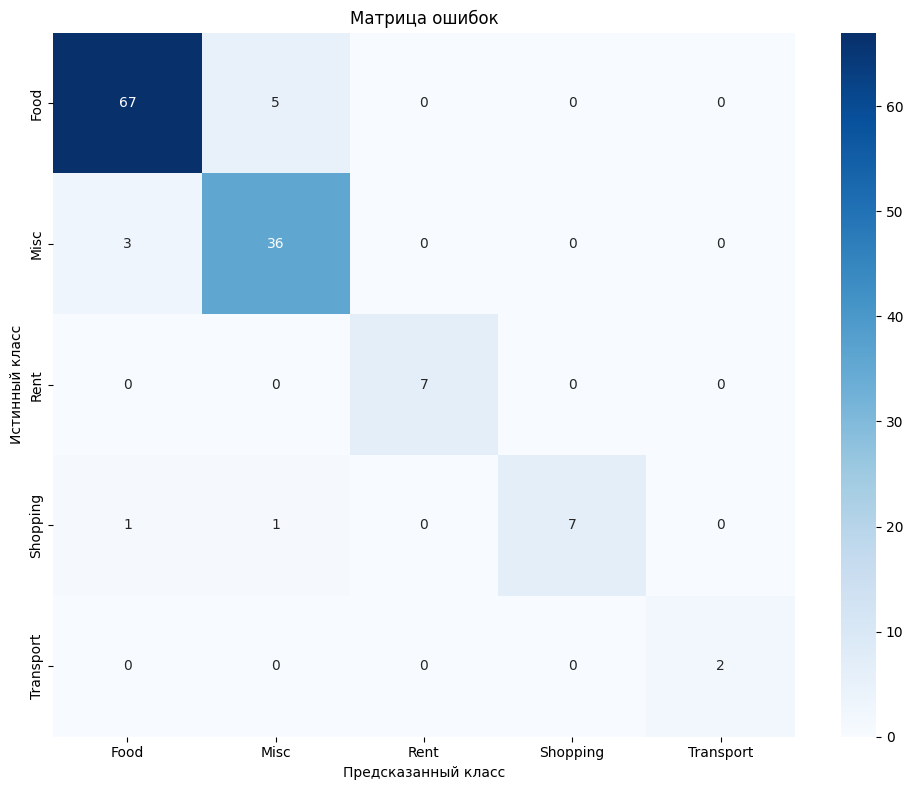


Важность признаков:
               feature  importance
1           Amount_Abs    0.292521
0               Amount    0.250197
6    Is_Small_Negative    0.106442
5   Is_Medium_Negative    0.093756
7                Month    0.065634
8                  Day    0.050927
3          Is_Negative    0.042338
9            DayOfWeek    0.036395
2          Is_Positive    0.032301
10        Is_FirstWeek    0.014266
11          Is_Weekend    0.011404
13             Has_E11    0.002491
4    Is_Large_Positive    0.001329
12            Has_CHAS    0.000000


In [10]:
print("\n" + "="*80)
print("ОБУЧЕНИЕ МОДЕЛИ")
print("="*80)

# Простая модель Random Forest
print("Обучаем Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Оценка на тестовых данных
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy модели: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Матрица ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nВажность признаков:")
print(feature_importance)

In [11]:
class RuleBasedClassifier:

    def __init__(self, ml_model=None):
        self.ml_model = ml_model
        self.category_mapping = category_mapping
        print("✓ Классификатор инициализирован")

    def predict_by_rules(self, transaction_data):

        date = pd.to_datetime(transaction_data.get('date', datetime.now()))
        amount = transaction_data.get('amount', 0)
        refno = str(transaction_data.get('ref_no', '')).upper()

        if amount > 5000:
            return 'Salary', 0.99, 'rule'
        elif 'CHAS' in refno and amount > 0:
            return 'Salary', 0.99, 'rule'

        if amount < -2000 and amount > -15000 and date.day <= 7:
            return 'Rent', 0.98, 'rule'

        transport_amounts = [-3062, -1718, -500, -100, -50, -200]
        if amount in transport_amounts:
            return 'Transport', 0.97, 'rule'

        if -500 < amount < -10 and amount % 1 != 0:
            return 'Food', 0.85, 'rule'

        if -10000 < amount < -100:
            if amount not in transport_amounts:
                return 'Shopping', 0.80, 'rule'

        return None, 0, 'rule'

    def predict_with_ml(self, transaction_data):
        """Предсказание с помощью ML модели"""

        if self.ml_model is None:
            return 'Misc', 0.5, 'ml_fallback'

        # Создаем признаки для ML модели
        date = pd.to_datetime(transaction_data.get('date', datetime.now()))
        amount = transaction_data.get('amount', 0)
        refno = str(transaction_data.get('ref_no', '')).upper()

        features = {
            'Amount': amount,
            'Amount_Abs': abs(amount),
            'Is_Positive': 1 if amount > 0 else 0,
            'Is_Negative': 1 if amount < 0 else 0,
            'Is_Large_Positive': 1 if amount > 5000 else 0,
            'Is_Medium_Negative': 1 if (-10000 < amount < -100) else 0,
            'Is_Small_Negative': 1 if (-500 < amount < 0) else 0,
            'Month': date.month,
            'Day': date.day,
            'DayOfWeek': date.dayofweek,
            'Is_FirstWeek': 1 if date.day <= 7 else 0,
            'Is_Weekend': 1 if date.dayofweek >= 5 else 0,
            'Has_CHAS': 1 if 'CHAS' in refno else 0,
            'Has_E11': 1 if 'E+11' in refno else 0,
        }

        X_new = pd.DataFrame([features])[feature_columns].fillna(0)

        try:
            prediction = self.ml_model.predict(X_new)[0]
            probabilities = self.ml_model.predict_proba(X_new)[0]

            category = self.category_mapping[prediction]
            confidence = float(probabilities[prediction])

            return category, confidence, 'ml'
        except:
            return 'Misc', 0.5, 'ml_error'

    def predict(self, transaction_data, use_ml=True):
        """Основной метод предсказания"""

        rule_category, rule_confidence, rule_method = self.predict_by_rules(transaction_data)

        if rule_category is not None:
            return {
                'category': rule_category,
                'confidence': rule_confidence,
                'method': rule_method,
                'is_rule_based': True
            }

        if use_ml and self.ml_model is not None:
            ml_category, ml_confidence, ml_method = self.predict_with_ml(transaction_data)
            return {
                'category': ml_category,
                'confidence': ml_confidence,
                'method': ml_method,
                'is_rule_based': False
            }

        return {
            'category': 'Misc',
            'confidence': 0.5,
            'method': 'fallback',
            'is_rule_based': False
        }

    def batch_predict(self, transactions_list, use_ml=True):
        """Пакетное предсказание"""
        return [self.predict(t, use_ml) for t in transactions_list]

# Создаем классификатор
print("\nСоздание RuleBasedClassifier...")
classifier = RuleBasedClassifier(ml_model=rf_model)
print("✓ Классификатор создан")


Создание RuleBasedClassifier...
✓ Классификатор инициализирован
✓ Классификатор создан


In [17]:
print("\n" + "="*80)
print("ТЕСТИРОВАНИЕ КЛАССИФИКАТОРА НА ПРАВИЛАХ")
print("="*80)

# Тестовые данные
test_cases = [
    {'desc': 'Зарплата (больше 5000)', 'date': '2023-01-25', 'amount': 34800.0, 'ref_no': 'REF001', 'expected': 'Salary'},
    {'desc': 'Зарплата (CHAS в refno)', 'date': '2023-02-24', 'amount': 24769.0, 'ref_no': 'CHASH32649207986', 'expected': 'Salary'},
    {'desc': 'Аренда (1 число, крупный расход)', 'date': '2023-01-01', 'amount': -3950.0, 'ref_no': '3.00E+11', 'expected': 'Rent'},
    {'desc': 'Аренда (3 число)', 'date': '2023-03-03', 'amount': -6490.0, 'ref_no': '3.06E+11', 'expected': 'Rent'},
    {'desc': 'Аренда (5 число)', 'date': '2023-05-05', 'amount': -7310.0, 'ref_no': '3.24E+11', 'expected': 'Rent'},
    {'desc': 'Продукты (нецелая сумма)', 'date': '2023-01-14', 'amount': -173.75, 'ref_no': '3.01E+11', 'expected': 'Food'},
    {'desc': 'Транспорт (общественный)', 'date': '2023-12-10', 'amount': -3062.0, 'ref_no': '3.34E+11', 'expected': 'Transport'},
    {'desc': 'Транспорт (такси)', 'date': '2023-12-12', 'amount': -1718.0, 'ref_no': '3.35E+11', 'expected': 'Transport'},
    {'desc': 'Шоппинг (покупка товаров)', 'date': '2023-01-26', 'amount': -1081.0, 'ref_no': '3.03E+11', 'expected': 'Shopping'},
    {'desc': 'Шоппинг (электроника)', 'date': '2023-02-11', 'amount': -2499.0, 'ref_no': '3.04E+11', 'expected': 'Shopping'},
    {'desc': 'Разные доходы', 'date': '2023-01-10', 'amount': 1289.0, 'ref_no': '3.38E+11', 'expected': 'Misc'},
    {'desc': 'Крупные разовые расходы', 'date': '2023-01-25', 'amount': -10000.0, 'ref_no': '3.39E+11', 'expected': 'Misc'},
]

print("\nРезультаты тестирования правил:")
print("-" * 80)

results = []
for test in test_cases:
    result = classifier.predict({
        'date': test['date'],
        'amount': test['amount'],
        'ref_no': test['ref_no']
    }, use_ml=False)  # Только правила, без ML

    is_correct = result['category'] == test['expected']
    status = '✅' if is_correct else '❌'

    print(f"{status} {test['desc']}:")
    print(f"  Сумма: {test['amount']} ₽")
    print(f"  Ожидалось: {test['expected']}, Предсказано: {result['category']}")
    print(f"  Метод: {result['method']}, Уверенность: {result['confidence']:.2%}")
    print()

    results.append(is_correct)

# Статистика
accuracy = sum(results) / len(results)
print(f"\n" + "="*80)
print(f"ИТОГОВАЯ ТОЧНОСТЬ ПРАВИЛ: {accuracy:.1%} ({sum(results)}/{len(results)})")

# Анализ по категориям
print(f"\nАНАЛИЗ ПО КАТЕГОРИЯМ:")
print("-" * 40)

category_results = {}
for i, test in enumerate(test_cases):
    category = test['expected']
    if category not in category_results:
        category_results[category] = {'total': 0, 'correct': 0}
    category_results[category]['total'] += 1
    if results[i]:
        category_results[category]['correct'] += 1

for category, stats in category_results.items():
    cat_accuracy = stats['correct'] / stats['total']
    print(f"{category:15} {cat_accuracy:.1%} ({stats['correct']}/{stats['total']})")


ТЕСТИРОВАНИЕ КЛАССИФИКАТОРА НА ПРАВИЛАХ

Результаты тестирования правил:
--------------------------------------------------------------------------------
✅ Зарплата (больше 5000):
  Сумма: 34800.0 ₽
  Ожидалось: Salary, Предсказано: Salary
  Метод: rule, Уверенность: 99.00%

✅ Зарплата (CHAS в refno):
  Сумма: 24769.0 ₽
  Ожидалось: Salary, Предсказано: Salary
  Метод: rule, Уверенность: 99.00%

✅ Аренда (1 число, крупный расход):
  Сумма: -3950.0 ₽
  Ожидалось: Rent, Предсказано: Rent
  Метод: rule, Уверенность: 98.00%

✅ Аренда (3 число):
  Сумма: -6490.0 ₽
  Ожидалось: Rent, Предсказано: Rent
  Метод: rule, Уверенность: 98.00%

✅ Аренда (5 число):
  Сумма: -7310.0 ₽
  Ожидалось: Rent, Предсказано: Rent
  Метод: rule, Уверенность: 98.00%

✅ Продукты (нецелая сумма):
  Сумма: -173.75 ₽
  Ожидалось: Food, Предсказано: Food
  Метод: rule, Уверенность: 85.00%

✅ Транспорт (общественный):
  Сумма: -3062.0 ₽
  Ожидалось: Transport, Предсказано: Transport
  Метод: rule, Уверенность: 97.00%

In [14]:
print("\n" + "="*80)
print("СОХРАНЕНИЕ МОДЕЛИ")
print("="*80)

# Сохраняем ML модель
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("✓ ML модель сохранена (rf_model.pkl)")

# Сохраняем классификатор
with open('classifier.pkl', 'wb') as f:
    pickle.dump(classifier, f)
print("✓ Классификатор сохранен (classifier.pkl)")

# Сохраняем метаданные
metadata = {
    'feature_columns': feature_columns,
    'category_mapping': category_mapping,
    'categories': categories.tolist()
}

with open('metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("✓ Метаданные сохранены (metadata.pkl)")

print("\nФайлы сохранены:")
!ls -la *.pkl


СОХРАНЕНИЕ МОДЕЛИ
✓ ML модель сохранена (rf_model.pkl)
✓ Классификатор сохранен (classifier.pkl)
✓ Метаданные сохранены (metadata.pkl)

Файлы сохранены:
-rw-r--r-- 1 root root 1075436 Dec  5 20:00 classifier.pkl
-rw-r--r-- 1 root root     328 Dec  5 20:00 metadata.pkl
-rw-r--r-- 1 root root 1075305 Dec  5 20:00 rf_model.pkl


In [15]:
print("\n" + "="*80)
print("ИНСТРУКЦИЯ ПО ИСПОЛЬЗОВАНИЮ:")
print("="*80)
print("""
1. Для предсказания категории транзакции:

   from datetime import datetime
   import pickle

   # Загрузка классификатора
   with open('classifier.pkl', 'rb') as f:
       classifier = pickle.load(f)

   # Предсказание
   result = classifier.predict({
       'date': '2023-01-25',
       'amount': 35000.0,
       'ref_no': 'CHAS123456'
   })

   print(f"Категория: {result['category']}")
   print(f"Уверенность: {result['confidence']:.2%}")
   print(f"Метод: {result['method']}")

2. Для пакетной обработки:

   transactions = [
       {'date': '2023-01-25', 'amount': 35000.0, 'ref_no': 'CHAS123456'},
       {'date': '2023-01-01', 'amount': -5000.0, 'ref_no': '3.00E+11'},
   ]

   results = classifier.batch_predict(transactions)
   for res in results:
       print(f"Категория: {res['category']}, Уверенность: {res['confidence']:.2%}")
""")


ИНСТРУКЦИЯ ПО ИСПОЛЬЗОВАНИЮ:

1. Для предсказания категории транзакции:
   
   from datetime import datetime
   import pickle
   
   # Загрузка классификатора
   with open('classifier.pkl', 'rb') as f:
       classifier = pickle.load(f)
   
   # Предсказание
   result = classifier.predict({
       'date': '2023-01-25',
       'amount': 35000.0,
       'ref_no': 'CHAS123456'
   })
   
   print(f"Категория: {result['category']}")
   print(f"Уверенность: {result['confidence']:.2%}")
   print(f"Метод: {result['method']}")
   
2. Для пакетной обработки:
   
   transactions = [
       {'date': '2023-01-25', 'amount': 35000.0, 'ref_no': 'CHAS123456'},
       {'date': '2023-01-01', 'amount': -5000.0, 'ref_no': '3.00E+11'},
   ]
   
   results = classifier.batch_predict(transactions)
   for res in results:
       print(f"Категория: {res['category']}, Уверенность: {res['confidence']:.2%}")



In [16]:
print("\n" + "="*80)
print("ТЕСТ НА НОВЫХ ДАННЫХ")
print("="*80)

# Пример использования классификатора
new_transactions = [
    {'date': '2024-01-15', 'amount': 45000.0, 'ref_no': 'CHAS987654'},
    {'date': '2024-01-05', 'amount': -7000.0, 'ref_no': '3.50E+11'},
    {'date': '2024-01-10', 'amount': -125.50, 'ref_no': 'SHOP123'},
    {'date': '2024-01-20', 'amount': -1718.0, 'ref_no': 'TAXI456'},
]

print("Предсказания для новых транзакций:")
for i, trans in enumerate(new_transactions):
    result = classifier.predict(trans)
    print(f"\nТранзакция {i+1}:")
    print(f"  Дата: {trans['date']}")
    print(f"  Сумма: {trans['amount']} ₽")
    print(f"  RefNo: {trans['ref_no']}")
    print(f"  Категория: {result['category']}")
    print(f"  Уверенность: {result['confidence']:.2%}")
    print(f"  Метод: {result['method']}")


ТЕСТ НА НОВЫХ ДАННЫХ
Предсказания для новых транзакций:

Транзакция 1:
  Дата: 2024-01-15
  Сумма: 45000.0 ₽
  RefNo: CHAS987654
  Категория: Salary
  Уверенность: 99.00%
  Метод: rule

Транзакция 2:
  Дата: 2024-01-05
  Сумма: -7000.0 ₽
  RefNo: 3.50E+11
  Категория: Rent
  Уверенность: 98.00%
  Метод: rule

Транзакция 3:
  Дата: 2024-01-10
  Сумма: -125.5 ₽
  RefNo: SHOP123
  Категория: Food
  Уверенность: 85.00%
  Метод: rule

Транзакция 4:
  Дата: 2024-01-20
  Сумма: -1718.0 ₽
  RefNo: TAXI456
  Категория: Transport
  Уверенность: 97.00%
  Метод: rule
